In [1]:
# try perturbing the starting locations

In [1]:
import os
import sys
import glob
import numpy as np
import numpy.matlib
import ase.atoms
import ase.io.gaussian
import ase.visualize
import ase.optimize

# need this set to represent the RMG molecule and get the rotors
DFT_DIR = os.environ['DFT_DIR']
sys.path.append(DFT_DIR)
sys.path.append(os.environ['DATABASE_DIR'])
import autotst_wrapper
import autotst.reaction
import autotst.species
import database_fun

import rmgpy.constants

import xtb.ase.calculator


import arkane.ess  # just to check our answers

import matplotlib.pyplot as plt
%matplotlib inline

/home/harris.se/rmg/RMG-Py/rmgpy/rmg/reactors.py:53: RuntimeWarning: Unable to import Julia dependencies, original error: [Errno 2] No such file or directory: 'julia': 'julia'
  warnings.warn("Unable to import Julia dependencies, original error: " + str(e), RuntimeWarning)


Loading DFT database from /work/westgroup/harris.se/autoscience/reaction_calculator/database


In [2]:
# Get the rmg species
species_index = 84
rmg_species = database_fun.index2species(species_index)
species_smiles = rmg_species.smiles
conformer_dir = os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'conformers')
species_file = autotst_wrapper.get_lowest_valid_conformer(conformer_dir)

# make the autotst species object
autotst_cf = autotst.species.Conformer(smiles=species_smiles)
with open(species_file, 'r') as f:
    atoms = ase.io.gaussian.read_gaussian_out(f)
    assert not autotst_wrapper.bonds_too_large(None, species_index, atoms=atoms)
    
autotst_cf._ase_molecule = atoms
autotst_cf.update_coords_from(mol_type="ase")
torsions = autotst_cf.get_torsions()
n_rotors = len(torsions)

2025-04-04 10:41:18.858703 Bonds too large for conformer, trying reorder...
2025-04-04 10:41:18.984905 Bonds too large for conformer /work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermo/species_0084/conformers/conformer_0005.log, blacklisting...
2025-04-04 10:41:19.498992 Lowest energy conformer is /work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermo/species_0084/conformers/conformer_0002.log


In [3]:
# Get both rigid and relaxed energies
rotor_index = 0
N = 1000

np.random.seed(400)


angles = np.linspace(0, 360, 21)
energies = np.zeros((N, len(angles)))

avg_bond_length = np.average(atoms.get_all_distances())
alpha = 0.05  # standard deviation to go into normal distribution, based on average bond length
sigma = alpha * avg_bond_length
perturbation_matrix = np.random.normal(loc=0.0, scale=sigma, size=(N, len(atoms), 3))
perturbation_matrix[0, :, :] = 0  # start with the baseline
for i in range(N):
    atoms = autotst_cf.get_ase_mol()
    atoms.positions += perturbation_matrix[i, :, :]
    
    starting_dihedral = atoms.get_dihedral(
        autotst_cf.torsions[rotor_index].atom_indices[0],
        autotst_cf.torsions[rotor_index].atom_indices[1],
        autotst_cf.torsions[rotor_index].atom_indices[2],
        autotst_cf.torsions[rotor_index].atom_indices[3],
    )

    for angle_index in range(len(angles)):
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        energies[i, angle_index] = atoms.get_potential_energy()
    if i % 100 == 0:
        print(i)


0
100
200
300
400
500
600
700
800
900


In [7]:
energies *= rmgpy.constants.Na * rmgpy.constants.e / 1000.0

In [61]:
np.matrix(np.min(energies, axis=1)).transpose().shape

(100, 1)

In [70]:
energies - np.matlib.repmat(np.matrix(np.min(energies, axis=1)).transpose(), 1, energies.shape[1])

matrix([[0.00000000e+00, 1.27414022e-01, 6.74218708e-01, ...,
         3.10743244e-01, 1.34385982e-01, 5.68434189e-13],
        [1.04084897e-01, 8.66755546e-01, 3.55933424e+00, ...,
         7.32800439e-02, 0.00000000e+00, 1.04084897e-01],
        [1.92389912e-01, 0.00000000e+00, 1.86510784e+01, ...,
         8.13850378e-01, 5.61357715e-01, 1.92389912e-01],
        ...,
        [3.41060513e-13, 1.29034683e-01, 3.87058279e-01, ...,
         2.78460970e-01, 6.03430561e-02, 0.00000000e+00],
        [0.00000000e+00, 3.43298921e-01, 7.94293420e-01, ...,
         3.12546219e-01, 3.93709709e-02, 6.82121026e-13],
        [0.00000000e+00, 1.65748710e-01, 8.30874855e-01, ...,
         3.82939340e-01, 1.15404239e-01, 5.68434189e-13]])

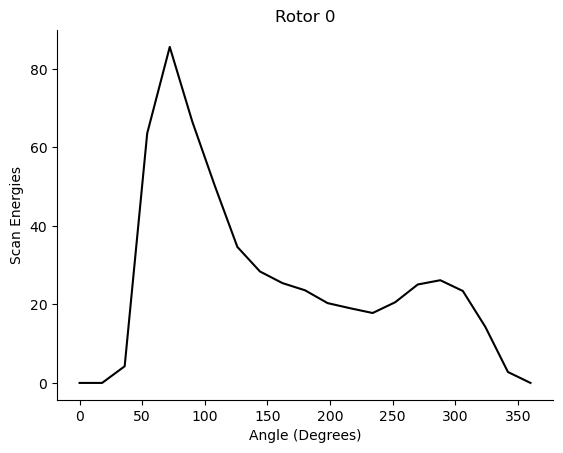

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
normalized_results = energies - np.matlib.repmat(np.matrix(np.min(energies, axis=1)).transpose(), 1, energies.shape[1])
# for i in range(N):
#     plt.plot(angles, energies[i, :] - np.min(energies[i, :]), color=colors[0], alpha=0.1)
# plt.plot(angles, np.median(normalized_results, axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 10,  axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 25,  axis=0).transpose(), color='black')
plt.plot(angles, np.percentile(normalized_results, 10,  axis=0).transpose(), color='black')
    
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.xlabel(f'Angle (Degrees)')
plt.ylabel(f'Scan Energies')
plt.title(f'Rotor {rotor_index}')
# plt.legend()
plt.show()

In [35]:
i = 2
atoms = autotst_cf.get_ase_mol()
atoms.positions += perturbation_matrix[i, :, :]


ase.visualize.view(atoms, viewer='x3d')

# Optimization but rotate from starting position

In [17]:
# Get both rigid and relaxed energies
rotor_index = 0
N = 10

np.random.seed(400)


angles = np.linspace(0, 360, 21)
energies = np.zeros((N, len(angles)))

avg_bond_length = np.average(atoms.get_all_distances())
alpha = 0.05  # standard deviation to go into normal distribution, based on average bond length
sigma = alpha * avg_bond_length
perturbation_matrix = np.random.normal(loc=0.0, scale=sigma, size=(N, len(atoms), 3))
perturbation_matrix[0, :, :] = 0  # start with the baseline
for i in range(N):
    

    for angle_index in range(len(angles)):
        atoms = autotst_cf.get_ase_mol()
        

        starting_dihedral = atoms.get_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
        )
        atoms.positions += perturbation_matrix[i, :, :]
        
        
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        # now do the optimization
        opt = ase.optimize.BFGS(atoms, logfile=None)
        opt.run(fmax=0.20, steps=1e6)
        energies[i, angle_index] = atoms.get_potential_energy() * rmgpy.constants.Na * rmgpy.constants.e / 1000.0
#     if i % 100 == 0:
#         print(i)


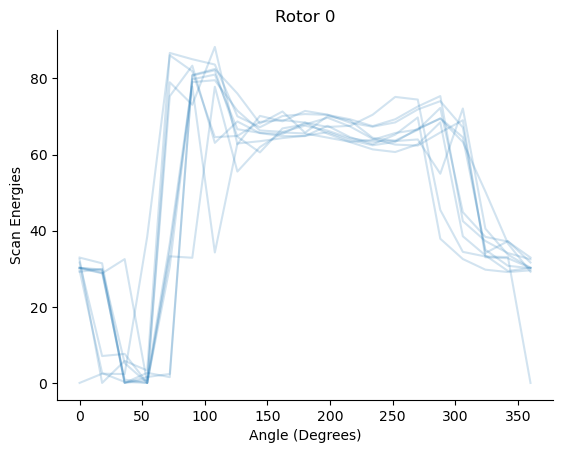

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
normalized_results = energies - np.matlib.repmat(np.matrix(np.min(energies, axis=1)).transpose(), 1, energies.shape[1])
for i in range(N):
    plt.plot(angles, energies[i, :] - np.min(energies[i, :]), color=colors[0], alpha=0.2)
# plt.plot(angles, np.median(normalized_results, axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 10,  axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 25,  axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 10,  axis=0).transpose(), color='black')
    
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.xlabel(f'Angle (Degrees)')
plt.ylabel(f'Scan Energies')
plt.title(f'Rotor {rotor_index}')
# plt.legend()
plt.show()

# Perturb start and then just rotate through

In [19]:
# Get both rigid and relaxed energies
rotor_index = 0
N = 10

np.random.seed(400)


angles = np.linspace(0, 360, 21)
rotate_angle = angles[1] - angles[0]
energies = np.zeros((N, len(angles)))

avg_bond_length = np.average(atoms.get_all_distances())
alpha = 0.05  # standard deviation to go into normal distribution, based on average bond length
sigma = alpha * avg_bond_length
perturbation_matrix = np.random.normal(loc=0.0, scale=sigma, size=(N, len(atoms), 3))
perturbation_matrix[0, :, :] = 0  # start with the baseline
for i in range(N):
    
    atoms = autotst_cf.get_ase_mol()
    atoms.calc = xtb.ase.calculator.XTB()
    atoms.positions += perturbation_matrix[i, :, :]
    
    # now do the optimization
    angle_index = 0
    opt = ase.optimize.BFGS(atoms, logfile=None)
    opt.run(fmax=0.20, steps=1e6)
    energies[i, angle_index] = atoms.get_potential_energy() * rmgpy.constants.Na * rmgpy.constants.e / 1000.0
    
    
    for angle_index in range(1, len(angles)):
        # rotate the dihedral
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            rotate_angle,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        opt = ase.optimize.BFGS(atoms, logfile=None)
        opt.run(fmax=0.20, steps=1e6)
        energies[i, angle_index] = atoms.get_potential_energy() * rmgpy.constants.Na * rmgpy.constants.e / 1000.0
    print(i)


0
1
2
3
4
5
6
7
8
9


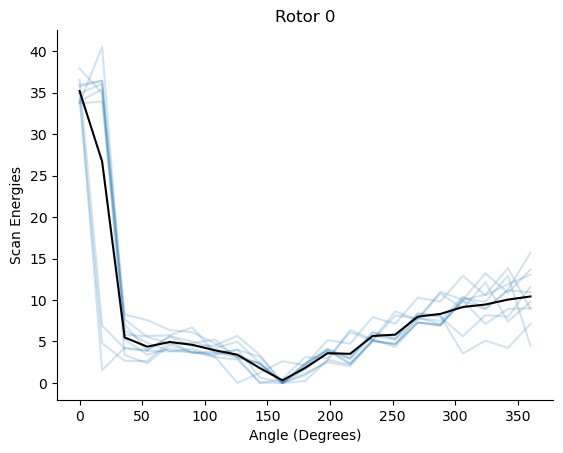

In [22]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
normalized_results = energies - np.matlib.repmat(np.matrix(np.min(energies, axis=1)).transpose(), 1, energies.shape[1])
for i in range(N):
    plt.plot(angles, energies[i, :] - np.min(energies[i, :]), color=colors[0], alpha=0.2)
# plt.plot(angles, np.median(normalized_results, axis=0).transpose(), color='black')
plt.plot(angles, np.mean(normalized_results, axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 10,  axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 25,  axis=0).transpose(), color='black')
# plt.plot(angles, np.percentile(normalized_results, 10,  axis=0).transpose(), color='black')
    
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.xlabel(f'Angle (Degrees)')
plt.ylabel(f'Scan Energies')
plt.title(f'Rotor {rotor_index}')
# plt.legend()
plt.show()